# Análisis de reviews de películas utilizando Redes Neuronales Recurrentes 

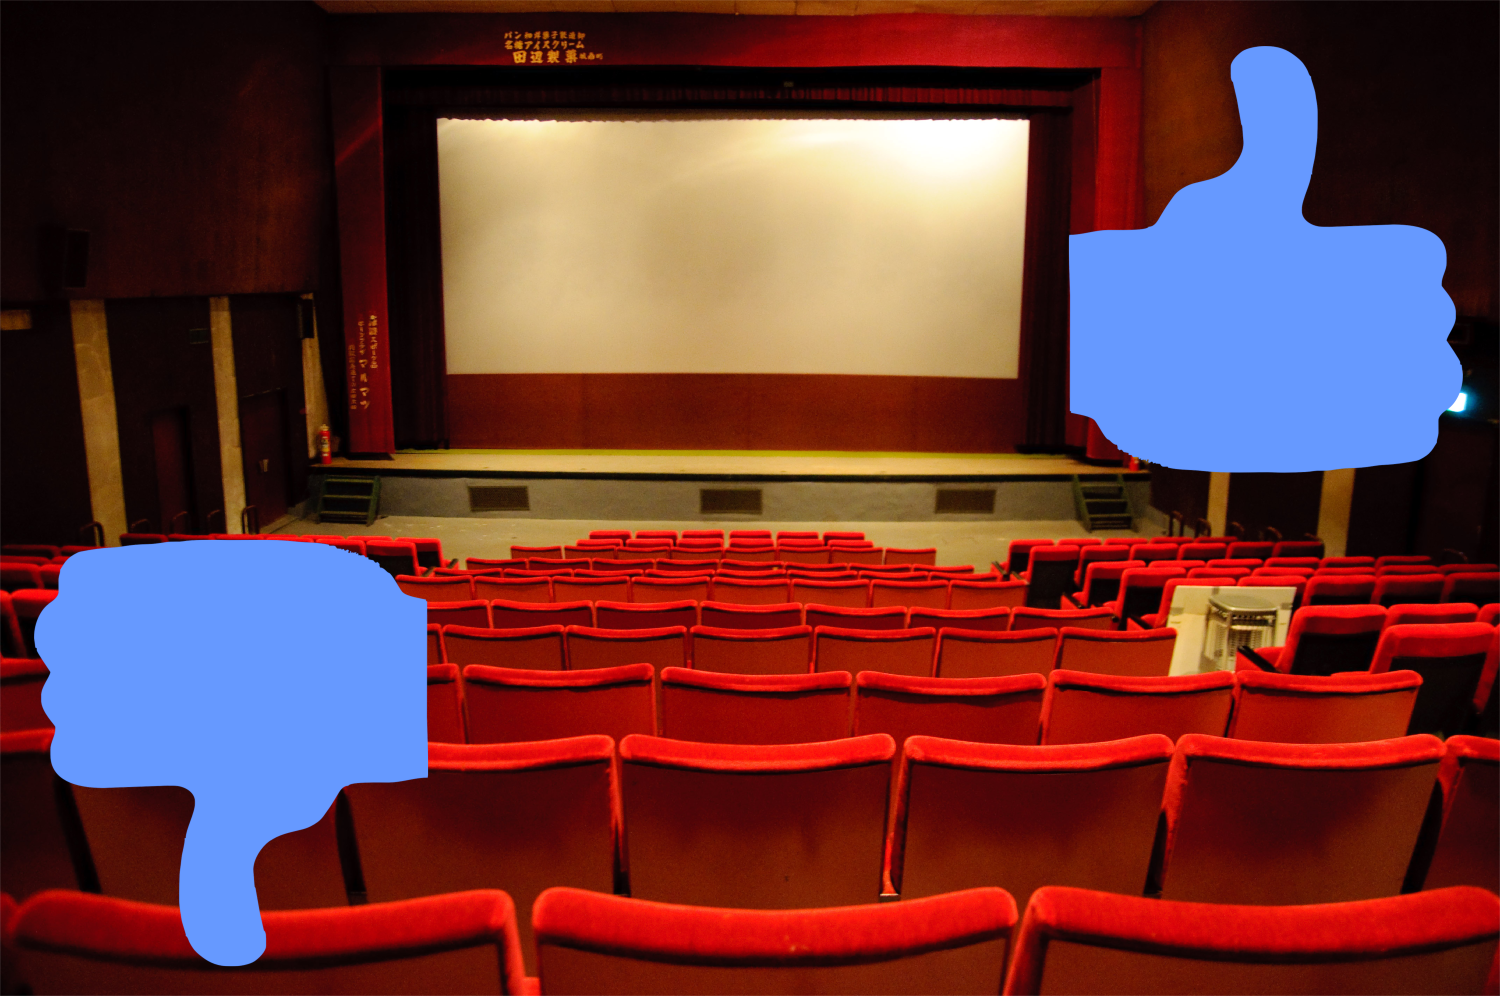

En este notebook analizaremos el sentimiento (positivo o negativo), expresado en un conjunto de reviews de películas en IMDB. Para ello utilizaremos word embeddings y redes neuronales recurrentes

## Carga de datos

Utilizaremos una parte de la base de datos de IMDB de reseñas de películas (`reviews.csv`), con una nota entre 0-10. Por simplicidad, consideraremos solamente reseñas buenas (nota superior a 7) y malas (nota inferior a 4). 

Carga los datos en dos variables: `text`, que contenga cada una de las reseñas e `y`, que contenga las etiquetas

In [3]:
import pandas as pd
data = pd.read_csv('reviews.csv', sep ='\t')
text = data['text']
y = data['sentiment'].values

In [5]:
data.sentiment.value_counts(normalize=True)

0    0.5012
1    0.4988
Name: sentiment, dtype: float64

Divide los datos en entrenamiento (`texts_train`, `y_train`) y test (`texts_test`, `y_test`), con una proporción 75%-25%

In [7]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(text,y,stratify=y,test_size=0.25)

## Procesamiento de los datos

No podemos introducir el texto directamente en la red neuronal, por lo que debemos transformarlo en una representación vectorial. Para ello, vamos a **tokenizar** el texto en palabras (o tokens), y asignar un identificador único a cada palabra encontrada en el texto. 

In [8]:
from keras.preprocessing.text import Tokenizer

Tenemos que indicar el máximo número de palabras diferentes que queremos representar. Si nuestro texto tiene más palabras que ese número, las palabras menos frecuentes se descartan. Escogeremos un valor de 1000 para este caso particular

In [9]:
maxwords = 1000
tokenizer = Tokenizer(num_words=maxwords)

A continuación tenemos que hacer un **fit** del Tokenizer para los textos de entrenamiento

In [10]:
tokenizer.fit_on_texts(texts_train)

La siguiente celda muestra el número de veces que el tokenizer ha encontrado cada una de las palabras en los textos de entrada

In [13]:
tokenizer.word_counts

OrderedDict([('i', 5944),
             ('tend', 16),
             ('to', 10364),
             ('like', 1559),
             ('character', 496),
             ('driven', 22),
             ('films', 535),
             ('also', 689),
             ('think', 515),
             ('hope', 103),
             ('davis', 24),
             ('turns', 88),
             ('in', 6896),
             ('consistently', 10),
             ('good', 1145),
             ('work', 304),
             ('so', 1483),
             ('had', 836),
             ('high', 160),
             ('hopes', 30),
             ('for', 3282),
             ('this', 5751),
             ('movie', 3231),
             ('those', 371),
             ('were', 788),
             ('soon', 87),
             ('dashed', 1),
             ('br', 7718),
             ('the', 25312),
             ('main', 173),
             ('flaw', 11),
             ('with', 3233),
             ('is', 8155),
             ('direction', 102),
             ('there', 1207),


Una vez entrenado el tokenizer podemos utilizarlo para vectorizar los textos. En particular, queremos transformar los textos en secuencias de índices de palabras

In [16]:
X_train = tokenizer.texts_to_sequences(texts_train)
X_test = tokenizer.texts_to_sequences(texts_test)

Ahora podemos ver cómo un texto se ha convertido en una lista de índices de palabras

In [21]:
texts_train

1897    I tend to like character-driven films. I also ...
2079    I just finished reading a book about Dillinger...
1410    In spite of sterling work by the supporting ac...
1090    First off, I'm a huge fan of 80s movies, and o...
342     Pieced (edited) together from dead body parts ...
                              ...                        
891     I love cinema so what I'm about to confess emb...
1341    Want to watch a scary horror film? Then steer ...
1022    My brother brought this movie home from the re...
2109    I was lucky enough to get to see this film man...
2131    I love this freekin movie! Walsh is a true mas...
Name: text, Length: 1875, dtype: object

In [23]:
X_train[0]

[10,
 5,
 35,
 106,
 102,
 10,
 79,
 105,
 463,
 530,
 8,
 49,
 169,
 37,
 10,
 66,
 302,
 15,
 11,
 17,
 142,
 69,
 536,
 7,
 7,
 1,
 286,
 16,
 11,
 17,
 6,
 1,
 469,
 45,
 23,
 3,
 175,
 4,
 141,
 12,
 23,
 936,
 1,
 17,
 176,
 366,
 4,
 1,
 106,
 14,
 1,
 4,
 1,
 681,
 106,
 9,
 138,
 169,
 15,
 70,
 29,
 30,
 11,
 58,
 25,
 898,
 132,
 14,
 3,
 322,
 80,
 3,
 17,
 7,
 7,
 45,
 23,
 633,
 16,
 1,
 114,
 14,
 67,
 9,
 6,
 725,
 12,
 1,
 100,
 8,
 3,
 17,
 196,
 3,
 2,
 122,
 52,
 8,
 3,
 262,
 253,
 33,
 118,
 34,
 537,
 10,
 160,
 232,
 12,
 1,
 100,
 8,
 1,
 871,
 8,
 1,
 17,
 7,
 7,
 362,
 1,
 966,
 266,
 67,
 224,
 328,
 45,
 13,
 3,
 53,
 201,
 8,
 1,
 564,
 4,
 1,
 17,
 12,
 13,
 380,
 7,
 7,
 456,
 15,
 117,
 59,
 10,
 417,
 13,
 538,
 11,
 17,
 8,
 189,
 161,
 967,
 4,
 454]

Con esto ya podemos entrenar una red secuencial. Sin embargo, por motivos de eficiencia se recomienda que todas las secuencias en los datos tengan el mismo número de elementos. Realizamos por tanto un padding de las secuencias para que tengan la misma longitud. Este proceso añade ceros a las secuencias cortas y corta las secuencias largas

In [26]:
from keras.preprocessing.sequence import pad_sequences
maxsequence = 300

X_train = pad_sequences(X_train, maxlen=maxsequence)
X_test = pad_sequences(X_test, maxlen=maxsequence)

In [40]:
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  10,
         5,  35, 106, 102,  10,  79, 105, 463, 530,   8,  49, 169,  37,
        10,  66, 302,  15,  11,  17, 142,  69, 536,   7,   7,   1, 286,
        16,  11,  17,   6,   1, 469,  45,  23,   3, 175,   4, 14

## Red LSTM con Embedding

Para transformar los índices de palabras utilizaremos una capa Embedding al inicio de la red. Esta capa transformará los índices de palabras a representaciones vectoriales que se ajustarán con el modelo junto con el resto de pesos de la red. Después de esta transformación, se utilizará una capa LSTM para analizar la secuencia completa, y por último una capa final de salida.

**Do it yourself**: Construye, compila y entrena una red de keras con la siguiente estructura:  
* Capa Embedding que produzca una representación de 64 elementos
* Capa LSTM con 32 neuronas
* Dropout de 0.9
* Capa densa con una neurona con función de activación sigmoide  

Recuerda que a la capa de Emberdding hay que especificarle como primer argumento el número máximo de palabras que utilizamos en el tokenizer. Además, la capa LSTM necesita incluir el parámetro *input_shape* como una tupla, incluyendo el número de elementos en las secuencias de entrada. 

Utiliza binary crossentropy como función objetivo y optimizador de tipo adam. Entrena la red con 10 épocas y mide el desempeño en el conjunto de test

In [41]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Activation
from tensorflow.keras.models import Sequential

In [46]:
model = Sequential()
model.add(Embedding(input_dim=maxwords, output_dim=64, input_length=maxsequence))
model.add(LSTM(32, input_shape=(maxsequence,)))
model.add(Dropout(0.4))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

model.fit(X_train, y_train, batch_size=64, epochs=5, validation_split=0.1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 64)           64000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 76,449
Trainable params: 76,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
27/27 [==============================] - 7s 147ms/step - loss: 0.6916 - accuracy: 0.5329 - val_loss: 0.687

Evalúa en el conjunto de test

In [47]:
model.evaluate(X_test,y_test)

20/20 [==============================] - 0s 21ms/step - loss: 0.4899 - accuracy: 0.7856


[0.4899129271507263, 0.7856000065803528]

## Stacked LSTMs

Las capas LSTM pueden agruparse para implementar modelos más complejos. Repite el entrenamiento de la red anterior, pero utsando 2 capas LSTM. 

In [51]:
model = Sequential()
model.add(Embedding(maxwords,64))
model.add(LSTM(32,input_shape=(maxsequence,), return_sequences=True))
model.add(LSTM(32,input_shape=(maxsequence,)))
model.add(Dropout(0.4))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

model.fit(X_train, y_train, batch_size=64, epochs=5, validation_split=0.1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 32)          12416     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 84,769
Trainable params: 84,769
Non-trainable params: 0
__________________________________________________

In [52]:
model.evaluate(X_test,y_test)

20/20 [==============================] - 1s 54ms/step - loss: 0.6262 - accuracy: 0.7456


[0.6262202262878418, 0.7455999851226807]

### Sin LSTM

In [59]:
from keras.layers.core import Flatten

model = Sequential()
model.add(Embedding(input_dim=maxwords, output_dim=64, input_length=maxsequence))
model.add(Flatten())
model.add(Dense(32,activation='tanh'))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

model.summary()

model.fit(X_train, y_train, batch_size=64, epochs=5, validation_split=0.1)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 300, 64)           64000     
_________________________________________________________________
flatten_4 (Flatten)          (None, 19200)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                614432    
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 678,465
Trainable params: 678,465
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
27/27 [==============================] - 1s 13ms/step - loss: 0.7038 - acc: 0.5483 - val_loss: 0.6969 - val_acc: 0.5585
Epoch 2/5
27/27 [==============================] - 0s 7ms/step - loss: 0.4745 - acc: 0.8838 - val_loss: 0.6468 - val

In [60]:
model.evaluate(X_test,y_test)

20/20 [==============================] - 0s 2ms/step - loss: 0.5841 - acc: 0.7248


[0.5841057896614075, 0.7247999906539917]